# 사용자기반 CF

In [65]:
import pandas as pd
import numpy as np

In [13]:
path = "udata.csv"
df = pd.read_csv(path, sep='\t', names =  ['UserID', 'ItemID', 'Rating', 'Timestamp'], header = None)

In [14]:
df

,UserID,ItemID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [15]:
type(df)

pandas.core.frame.DataFrame

In [16]:
df.head()

,UserID,ItemID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
df.shape

(100000, 4)

In [ ]:
# 분산 확인 

In [25]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

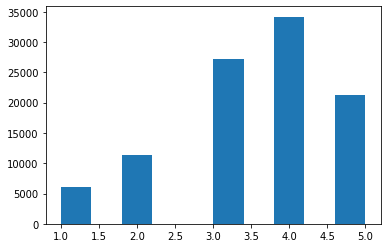

In [26]:
plt.hist(df['Rating'])

In [27]:
df.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

# 평가행렬 표현

In [34]:
#사용자 총 수 -> n_users 변수 생성
n_users = df.UserID.unique().shape[0]

In [30]:
#영화 총수 -> n_items 변수 생성
n_items = df['ItemID'].unique().shape[0]

In [38]:
#고유한 사용자와 영화 수 생성
print(str(n_users) + ' users')
print(str(n_items) + ' movies')

943 users
1682 movies


In [39]:
#각 셀에 평가 값을 저장 <- 크기가 n_users*n_items인 배열 값을 모두 0으로 생성
ratings = np.zeros((n_users, n_items))

In [40]:
#df의 각 튜플에서 행의 각 열에 대한 정보를 추출해 평가 행렬의 셀에 저장
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [42]:
ratings.shape #차원 확인

(943, 1682)

In [43]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

# 훈련 테스트 셋 생성

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
#테스트 크기 =0.33 / 랜덤시드 =42
ratings_train, ratings_test = train_test_split(ratings, test_size=0.33, random_state=42)

In [57]:
ratings_train.shape #트레인 차원 확인

(631, 1682)

In [58]:
ratings_test.shape #테스트 차원 확인

(312, 1682)

# UBCF 구축 - 사용자 기반 유사도 계산 (코사인 유사도)

In [61]:
import numpy as np
import sklearn

In [62]:
dist_out = 1- sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [63]:
dist_out

array([[1.        , 0.36475764, 0.44246231, ..., 0.02010641, 0.33107929,
        0.25638518],
       [0.36475764, 1.        , 0.42635255, ..., 0.06694419, 0.27339314,
        0.22337268],
       [0.44246231, 0.42635255, 1.        , ..., 0.06675756, 0.25424373,
        0.22320126],
       ...,
       [0.02010641, 0.06694419, 0.06675756, ..., 1.        , 0.04853428,
        0.05142508],
       [0.33107929, 0.27339314, 0.25424373, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.25638518, 0.22337268, 0.22320126, ..., 0.05142508, 0.1198022 ,
        1.        ]])


# 활성 사용자의 알려지지 않은 평가 예측

In [67]:
user_pred = dist_out.dot(ratings_train) / np.array([np.abs(dist_out).sum(axis=1)]).T

In [68]:
user_pred

array([[2.46573349, 0.82987753, 0.46745119, ..., 0.        , 0.01051423,
        0.00930566],
       [2.20129624, 0.5513313 , 0.44342882, ..., 0.        , 0.00682653,
        0.00629833],
       [2.23857808, 0.68874746, 0.45178516, ..., 0.        , 0.00863713,
        0.0084224 ],
       ...,
       [1.74346476, 0.40503715, 0.32435436, ..., 0.        , 0.00284126,
        0.0094319 ],
       [2.32393481, 0.81386209, 0.48334765, ..., 0.        , 0.01058346,
        0.01011386],
       [2.35304498, 0.59746852, 0.38845057, ..., 0.        , 0.00669755,
        0.00562433]])

In [85]:
from sklearn.metrics import mean_squared_error
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [86]:
get_mse(user_pred, ratings_train) #예측 오차율 확인

7.882193991551003

# K-최접 이웃과 사용자 기반 협업 필터링 - 최접 N 이웃찾기

In [87]:
from sklearn.neighbors import NearestNeighbors

In [89]:
k=5

In [90]:
neigh = NearestNeighbors(k,'cosine')

In [91]:
neigh.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [92]:
#각 사용자에 대해 가장 유사한 사용자를 찾고 사용자들의 유사도 값 계산
top_k_distances, top_k_users = neigh.kneighbors(ratings_train, return_distance=True)

In [93]:
top_k_distances.shape

(631, 5)

In [94]:
top_k_users.shape

(631, 5)

In [95]:
top_k_users[0] # 사용자 1과 가장 유사한 다섯 명의 사용자 확인

array([  0,  82, 511, 184, 207], dtype=int64)

In [100]:
#알려지지 않은 평가 예측
user_pred_k = np.zeros(ratings_train.shape)

In [106]:
for i in range(ratings_train.shape[0]):
    user_pred_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [107]:
user_pred_k.shape #예측 데이터 확인

(631, 1682)

In [108]:
user_pred_k

array([[3.25379713, 1.75556855, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.48370298, 0.        , 1.24948776, ..., 0.        , 0.        ,
        0.        ],
       [1.01011767, 0.73826825, 0.7451635 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 모델 개선 여부

In [109]:
get_mse(user_pred_k, ratings_train)

8.195606511453878

In [110]:
get_mse(user_pred_k, ratings_test)

11.602073790588975